<a href="https://colab.research.google.com/github/othmanebenlamlih/PFE/blob/main/PFE_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import math
from PIL import Image
from keras import layers
from keras.applications.resnet50 import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model


color = sns.color_palette()
%matplotlib inline

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files

In [5]:
#on adapte notre json file de notre kaggle profile
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benlamlihothmane","key":"ebc68494200b00eb5534850edcf3ab77"}'}

In [6]:
!mkdir -p ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
!ls ~/.kaggle

kaggle.json


In [9]:
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
#on se connecte a anotre kaggle data
!kaggle datasets download  "paultimothymooney/chest-xray-pneumonia"

 99% 2.27G/2.29G [00:52<00:00, 67.4MB/s]
100% 2.29G/2.29G [00:52<00:00, 46.8MB/s]


In [11]:
#le fichier est zip , on va unsiper le fichier pour acceder anotre data
!unzip chest-xray-pneumonia.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-04

# data

**chemin**

In [12]:
# Définir le chemin vers le répertoire de données
data_dir = Path('/content/chest_xray')

# Chemin vers le répertoire de données de train
train_dir = data_dir / 'train'

# Chemin vers le répertoire de données de validation
val_dir = data_dir / 'val'

# Chemin vers le répertoire de données de teste
test_dir = data_dir / 'test'

### cas normal

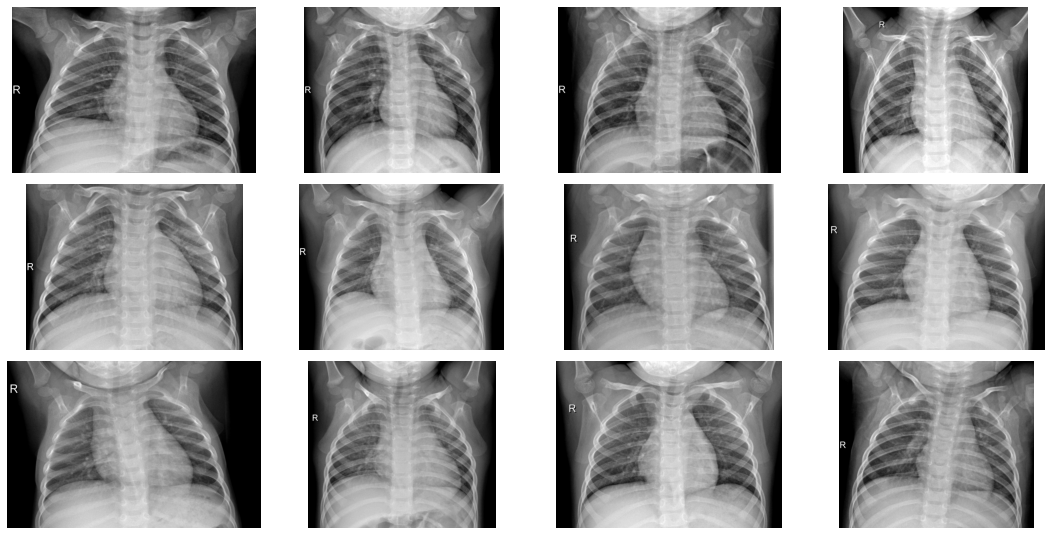

In [13]:
path = "/content/chest_xray/chest_xray/train/NORMAL"
#listdir =retourne une liste contenant les noms des entrées dans le répertoire donné par chemin
data_exemple = os.listdir(path)
plt.figure(figsize=(15, 10))

for i in range(12):
    plt.subplot(4, 4, i + 1)
    #imread =charge une image à partir du fichier spécifié
    img = plt.imread(os.path.join(path, data_exemple[i]))
    #imshow = affiche l'imagerie 
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

### cas pneumonia

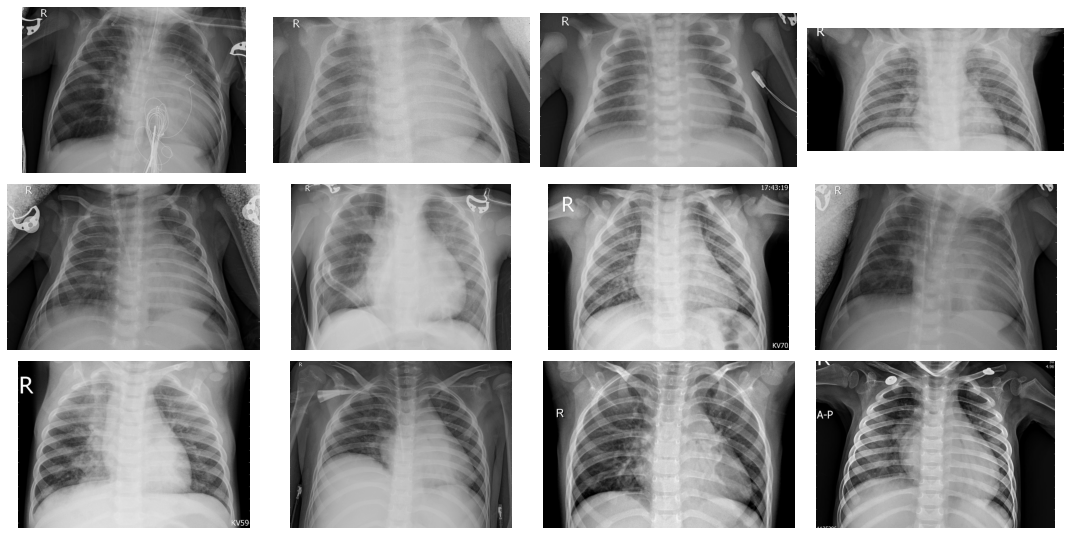

In [14]:
path = "/content/chest_xray/chest_xray/train/PNEUMONIA"
#listdir =retourne une liste contenant les noms des entrées dans le répertoire donné par chemin
data_exemple = os.listdir(path)
plt.figure(figsize=(15, 10))

for i in range(12):
    plt.subplot(4, 4, i + 1)
    #imread =charge une image à partir du fichier spécifié
    img = plt.imread(os.path.join(path, data_exemple[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

## Préparation des données

**validation**

In [15]:
#listdir =retourne une liste contenant les noms des entrées dans le répertoire donné par chemin
print("PNEUMONIA=",len(os.listdir(os.path.join(val_dir, 'PNEUMONIA'))))
print("NORMAL=",len(os.listdir(os.path.join(val_dir, 'NORMAL'))))

PNEUMONIA= 8
NORMAL= 8


**test**

In [16]:
#listdir =retourne une liste contenant les noms des entrées dans le répertoire donné par chemin
print("PNEUMONIA=",len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))))
print("NORMAL=",len(os.listdir(os.path.join(test_dir, 'NORMAL'))))

PNEUMONIA= 390
NORMAL= 234


**trainement**

In [17]:
#listdir =retourne une liste contenant les noms des entrées dans le répertoire donné par chemin
print("PNEUMONIA=",len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))))
print("NORMAL=",len(os.listdir(os.path.join(train_dir, 'NORMAL'))))

PNEUMONIA= 3875
NORMAL= 1341


Chacun des répertoires contient deux sous-répertoires:


*   **PNEUMONIE**: Ce répertoire contient les échantillons qui sont les cas de pneumonie.
*   **NORMAL**: Ce sont les échantillons qui décrivent le cas normal (pas de pneumonie).


### Préparation des données de trainement




In [18]:
#Récupérer le chemin  
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

#Obtenez la liste de toutes les images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

#Nous insérerons les données dans une liste vide x et y
train_data = []

# Passez en tous les cas normaux
for img in normal_cases:
    train_data.append((img,1,0))
    

# Passez en tous les cas pneumonie
for img in pneumonia_cases:
    train_data.append((img,0,1))

#nomée les atribut du tableau train_data
train_data = pd.DataFrame(train_data, columns=['image', 'NORMAL','PNEUMONIA'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head()

image  NORMAL  PNEUMONIA
0  /content/chest_xray/train/NORMAL/NORMAL2-IM-03...       1          0
1  /content/chest_xray/train/PNEUMONIA/person1069...       0          1
2  /content/chest_xray/train/PNEUMONIA/person952_...       0          1
3  /content/chest_xray/train/PNEUMONIA/person819_...       0          1
4  /content/chest_xray/train/PNEUMONIA/person1529...       0          1

In [19]:
# Get the counts for each class
print(len(os.listdir(os.path.join(train_dir, 'NORMAL'))))
print(len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))))


1341
3875


0    3875
1    1341
Name: NORMAL, dtype: int64


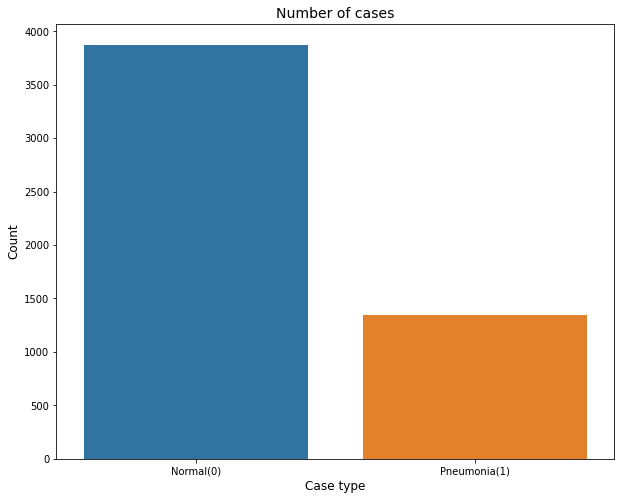

In [20]:
# conter le nombre data
cases_count = train_data['NORMAL'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), [ 'Normal(0)','Pneumonia(1)'])
plt.show()

In [21]:
cases_count

0    3875
1    1341
Name: NORMAL, dtype: int64

Comme vous pouvez le voir, les données sont très déséquilibrées. Nous avons presque trois cas de pneumonie ici par rapport aux cas normaux. Cette situation est tout à fait normale en ce qui concerne les données médicales. Les données seront toujours déséquilibrées. soit il y aura trop de cas normaux, soit il y aura trop de cas avec la maladie.

### Préparation des données de validation

In [22]:
#Récupérer le chemin  
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

#Obtenez la liste de toutes les images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

#Nous insérerons les données dans une liste vide x et y
val_data = []

# Passez en tous les cas normaux(Référencier par 0  )
for img in normal_cases:
    val_data.append((img,1,0))
    

# Passez en tous les cas pneumonie(Référencier par 1  )
for img in pneumonia_cases:
    val_data.append((img,0,1))


val_data = pd.DataFrame(val_data, columns=['image','NORMAL','PNEUMONIA'],index=None)

#Mélangez les données
val_data = val_data.sample(frac=1.).reset_index(drop=True)

#afficher
val_data.head()

image  NORMAL  PNEUMONIA
0  /content/chest_xray/val/PNEUMONIA/person1949_b...       0          1
1  /content/chest_xray/val/PNEUMONIA/person1954_b...       0          1
2  /content/chest_xray/val/NORMAL/NORMAL2-IM-1427...       1          0
3  /content/chest_xray/val/NORMAL/NORMAL2-IM-1436...       1          0
4  /content/chest_xray/val/NORMAL/NORMAL2-IM-1431...       1          0

In [23]:
val_data.shape

(16, 3)

In [24]:
#input de validation
val_data['image'].shape

(16,)

In [25]:
val_data['NORMAL'].shape

(16,)

alors aucune valeur manquante

In [26]:
# lancer un conteure pour chaque attribut
cases_count = val_data['NORMAL'].value_counts()
print(cases_count)

1    8
0    8
Name: NORMAL, dtype: int64


In [27]:
cases_count.index

Int64Index([1, 0], dtype='int64')

In [28]:
cases_count.values

array([8, 8])

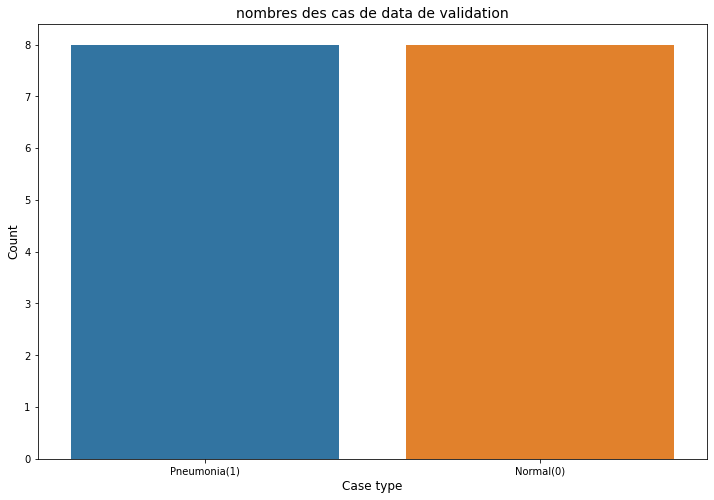

In [29]:
plt.figure(figsize=(12,8))
#x = soit 0 soit 1 
#y = la somme de chaque type
sns.barplot(x=cases_count.index, y= cases_count.values)

plt.title('nombres des cas de data de validation', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
#renomer les label de x 
plt.xticks(range(len(cases_count.index)), ['Pneumonia(1)','Normal(0)'])
plt.show()

### Préparation des données de test

In [30]:
#Récupérer le chemin  
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

#Obtenez la liste de toutes les images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

#Nous insérerons les données dans une liste vide x et y
test_data = []

# Passez en tous les cas normaux(Référencier par 0  )
for img in normal_cases:
    test_data.append((img,1,0))
    

# Passez en tous les cas pneumonie(Référencier par 1  )
for img in pneumonia_cases:
    test_data.append((img,0,1))


test_data = pd.DataFrame(test_data, columns=['image', 'NORMAL','PNEUMONIA'],index=None)

#Mélangez les données
test_data = test_data.sample(frac=1.).reset_index(drop=True)

#afficher
test_data.head()

image  NORMAL  PNEUMONIA
0  /content/chest_xray/test/PNEUMONIA/person75_vi...       0          1
1  /content/chest_xray/test/NORMAL/NORMAL2-IM-031...       1          0
2  /content/chest_xray/test/PNEUMONIA/person90_ba...       0          1
3  /content/chest_xray/test/NORMAL/NORMAL2-IM-028...       1          0
4  /content/chest_xray/test/NORMAL/NORMAL2-IM-034...       1          0

In [31]:
test_data.shape

(624, 3)

In [32]:
train_data.shape

(5216, 3)

In [33]:

cases_count = val_data['NORMAL'].value_counts()
print(cases_count)

1    8
0    8
Name: NORMAL, dtype: int64


In [34]:
cases_count.index

Int64Index([1, 0], dtype='int64')

In [35]:
cases_count.values

array([8, 8])

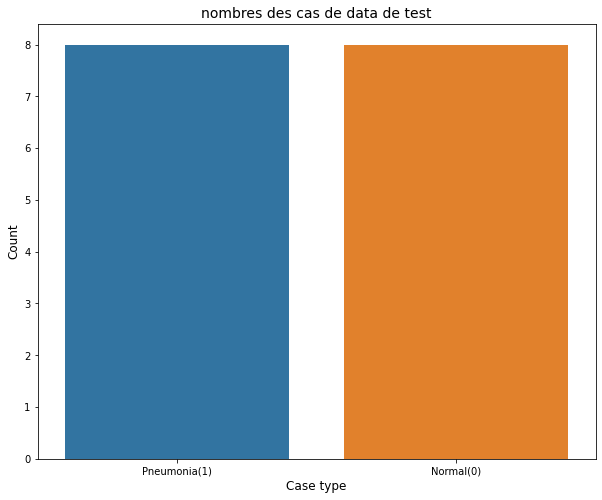

In [36]:
plt.figure(figsize=(10,8))
#x = soit 0 soit 1 
#y = la somme de chaque type
sns.barplot(x=cases_count.index, y= cases_count.values)

plt.title('nombres des cas de data de test', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
#renomer les label de x 
plt.xticks(range(len(cases_count.index)), ['Pneumonia(1)','Normal(0)'])
plt.show()

### visualisation data

In [37]:
#on va prendre quelque exemplaire
pneumonia_samples = (train_data[train_data['PNEUMONIA']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['NORMAL']==1]['image'].iloc[:5]).tolist()

#on cree une data de c'est exemple
samples = pneumonia_samples + normal_samples

#on affiche
def affiche(samples):
  f, ax = plt.subplots(2,5, figsize=(30,10))
  for i in range(10):
      img = imread(samples[i])
      ax[i//5, i%5].imshow(img, cmap='gray')
      if i<5:
          ax[i//5, i%5].set_title("Pneumonia")
      else:
          ax[i//5, i%5].set_title("Normal")
      ax[i//5, i%5].axis('off')
      ax[i//5, i%5].set_aspect('auto')
  plt.show()

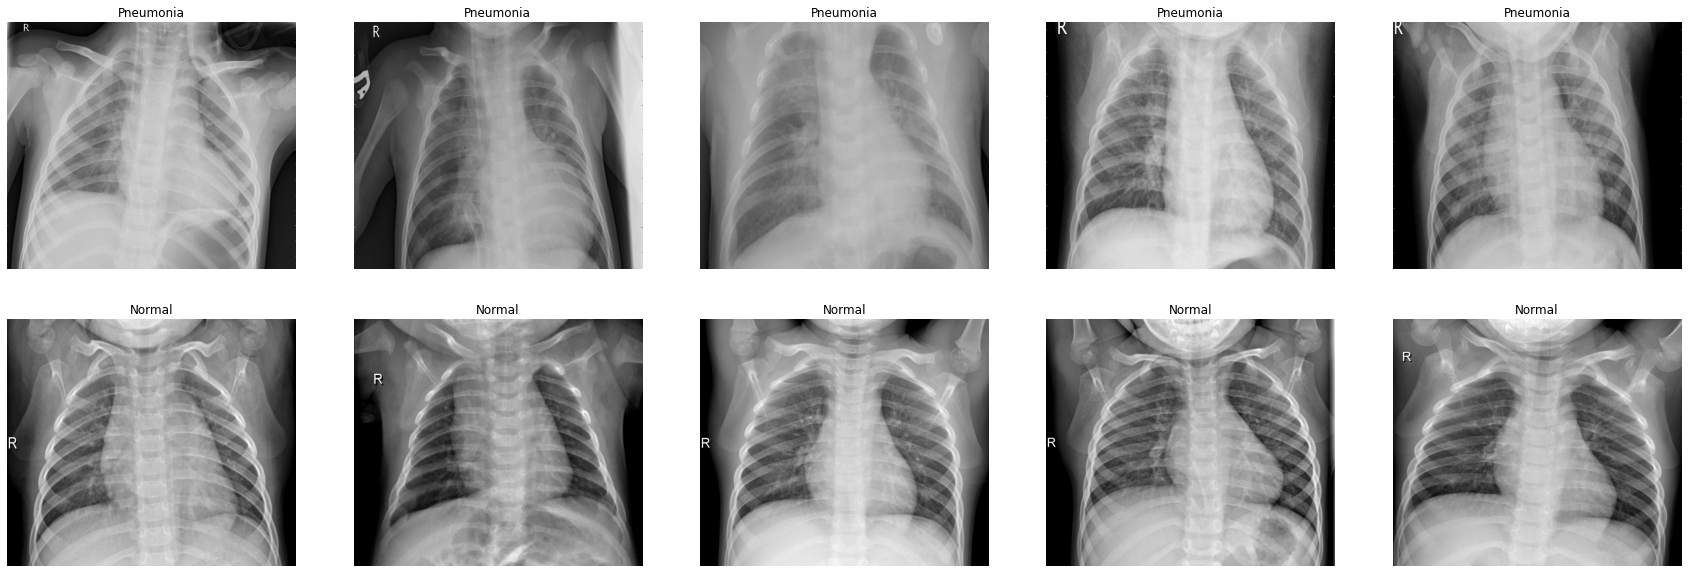

In [38]:
affiche(samples)

# VGG16 Model

In [39]:
from keras.applications.vgg16 import VGG16

In [40]:
#la taille de notre input
taille=(224, 224,3)
#importer le model vgg16
model_vgg16 = VGG16(input_shape=taille, include_top=False, weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [41]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## construction du modele

In [42]:
# Freeze the base_model
model_vgg16.trainable = False

In [43]:
model_vgg16.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [44]:
# ajouter un MaxPooling2D
x = layers.GlobalMaxPooling2D()(model_vgg16.output)
# ajouter une couche a  512 et ReLU comme activation
x = layers.Dense(512, activation='relu')(x)
# ajouter dropout rate of 0.5
x = layers.Dropout(0.002)(x)
# Ajout d’une couche entièrement connectée avec 256 unités cachées et activation ReLU
x = layers.Dense(256, activation='relu')(x)
# Ajout d’une couche entièrement connectée avec 128 unités cachées et activation ReLU
x = layers.Dense(128, activation='relu')(x)
# Ajouter une couche sigmoïde finale pour la classification
x = layers.Dense(2, activation='softmax')(x)

# Configurer et compiler le modèle
model = Model(model_vgg16.input, x)


In [45]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## gestion de data

In [46]:
train_data.head()

image  NORMAL  PNEUMONIA
0  /content/chest_xray/train/NORMAL/NORMAL2-IM-03...       1          0
1  /content/chest_xray/train/PNEUMONIA/person1069...       0          1
2  /content/chest_xray/train/PNEUMONIA/person952_...       0          1
3  /content/chest_xray/train/PNEUMONIA/person819_...       0          1
4  /content/chest_xray/train/PNEUMONIA/person1529...       0          1

In [47]:
x_train_data = []
y_train_data = []

for img in train_data['NORMAL']:
    if img == 1:
      y_train_data.append((1,0))
    else:
      y_train_data.append((0,1))

for img in train_data['image']:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    img = img.astype(np.float32)/255
    x_train_data.append(img)


In [48]:
x_train_data=np.array(x_train_data)
y_train_data=np.array(y_train_data)

In [49]:
x_train_data.shape

(5216, 224, 224, 3)

In [50]:
y_train_data.shape

(5216, 2)

In [51]:
x_val_data = []
y_val_data = []

for img in val_data['NORMAL']:
    if img == 1:
      y_val_data.append((1,0))
    else:
      y_val_data.append((0,1))

for img in val_data['image']:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    img = img.astype(np.float32)/255
    x_val_data.append(img)




In [52]:
x_val_data=np.array(x_val_data)
y_val_data=np.array(y_val_data)

In [53]:
y_val_data.shape

(16, 2)

In [54]:
x_val_data.shape

(16, 224, 224, 3)

augmentation de notre data

In [55]:
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [56]:
#datagen.fit(x_train_data)

In [57]:

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [58]:
history_vgg16 = model.fit(x_train_data, y_train_data, batch_size=64, epochs=3,
                    validation_data=(x_val_data, y_val_data))

Epoch 1/3
82/82 [==============================] - 112s 638ms/step - loss: 0.3685 - accuracy: 0.8363 - val_loss: 1.0268 - val_accuracy: 0.6875
Epoch 2/3
82/82 [==============================] - 36s 441ms/step - loss: 0.1391 - accuracy: 0.9460 - val_loss: 0.6847 - val_accuracy: 0.6875
Epoch 3/3
82/82 [==============================] - 36s 441ms/step - loss: 0.1017 - accuracy: 0.9608 - val_loss: 0.7363 - val_accuracy: 0.6875


## Fine Tuning Model

In [59]:
model_vgg16.trainable

False

In [60]:
model_vgg16.trainable = True

In [61]:
model_vgg16.trainable

True

In [62]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

In [64]:
history_vgg16 = model.fit(x_train_data, y_train_data, batch_size=64, epochs=12,
                    validation_data=(x_val_data, y_val_data))

Epoch 1/12
82/82 [==============================] - 130s 1s/step - loss: 5.9557 - acc: 0.7482 - val_loss: 1.2109 - val_acc: 0.6250
Epoch 2/12
82/82 [==============================] - 115s 1s/step - loss: 0.2770 - acc: 0.8726 - val_loss: 0.2463 - val_acc: 0.8750
Epoch 3/12
82/82 [==============================] - 115s 1s/step - loss: 0.1890 - acc: 0.9212 - val_loss: 2.3794 - val_acc: 0.5000
Epoch 4/12
82/82 [==============================] - 115s 1s/step - loss: 0.1411 - acc: 0.9404 - val_loss: 0.4596 - val_acc: 0.7500
Epoch 5/12
82/82 [==============================] - 116s 1s/step - loss: 0.1034 - acc: 0.9605 - val_loss: 0.2952 - val_acc: 0.8125
Epoch 6/12
82/82 [==============================] - 115s 1s/step - loss: 0.0851 - acc: 0.9675 - val_loss: 0.3921 - val_acc: 0.8125
Epoch 7/12
82/82 [==============================] - 115s 1s/step - loss: 0.0746 - acc: 0.9703 - val_loss: 0.2140 - val_acc: 0.8750
Epoch 8/12
82/82 [==============================] - 115s 1s/step - loss: 0.0750 - a

In [65]:
loss_val, acc_val = model.evaluate(x_val_data, y_val_data, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1/1 [==============================] - 0s 133ms/step - loss: 1.1604 - acc: 0.7500
Validation: accuracy = 0.750000  ;  loss_v = 1.160427


## **Testing**

### methode 1

In [66]:
x_test_data = []
y_test_data = []

for img in test_data['NORMAL']:
    if img == 1:
      y_test_data.append((1,0))
    else:
      y_test_data.append((0,1))

for img in test_data['image']:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    img = img.astype(np.float32)/255
    x_test_data.append(img)


x_test_data=np.array(x_test_data)
y_test_data=np.array(y_test_data)


on va tester notre model avec une data qui la deja traiter

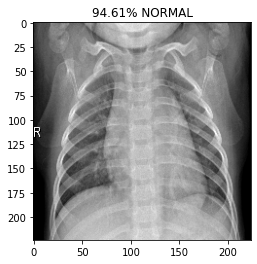

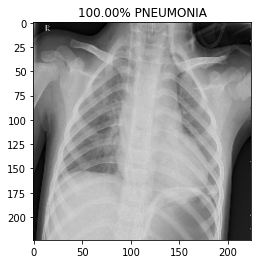

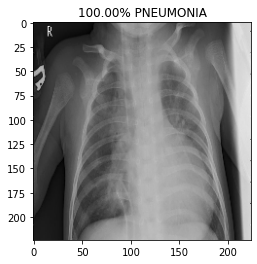

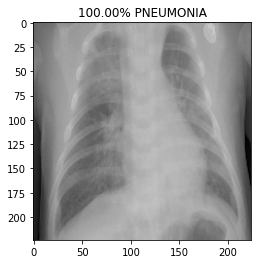

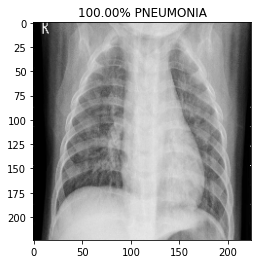

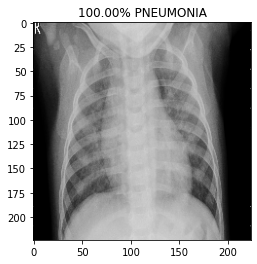

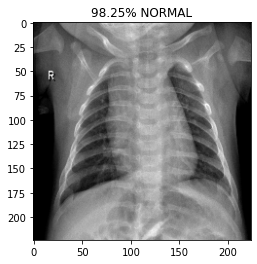

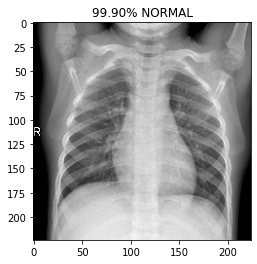

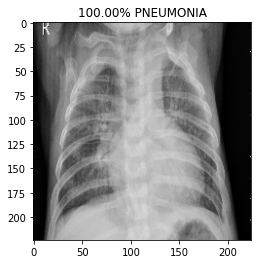

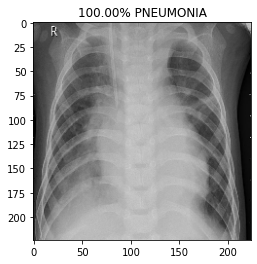

In [67]:
y_pred = model.predict(x_train_data, batch_size=64)
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% PNEUMONIA')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NORMAL')
  plt.imshow(x_train_data[index])
  plt.show()

### methode2

on va tester notre model avec une data c'est la premiere fois qui va  traiter

In [68]:

loss_test_vgg16, acc_test_vgg16 = model.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (loss_test_vgg16, acc_test_vgg16))

20/20 [==============================] - 4s 220ms/step - loss: 3.8597 - acc: 0.6955
Test: accuracy = 3.859661  ;  loss = 0.695513


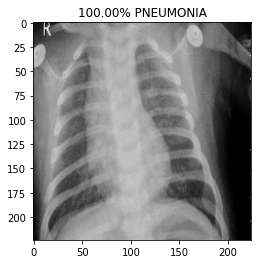

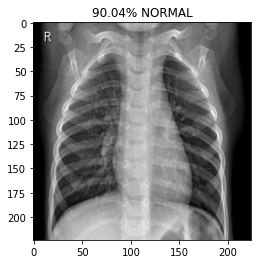

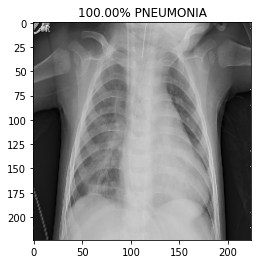

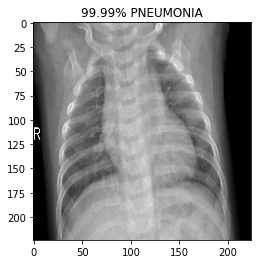

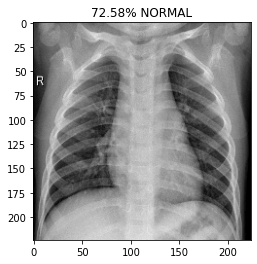

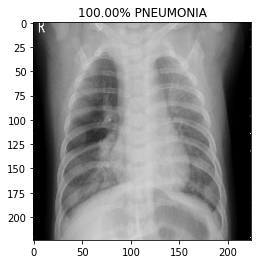

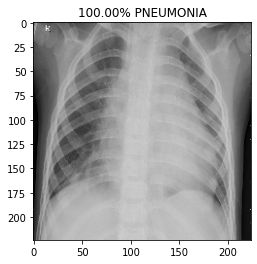

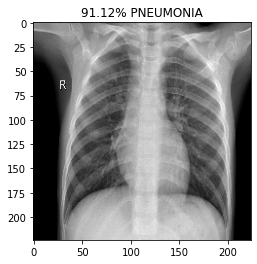

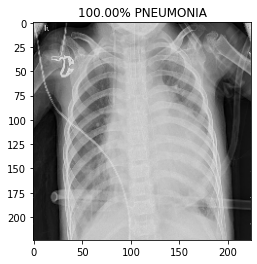

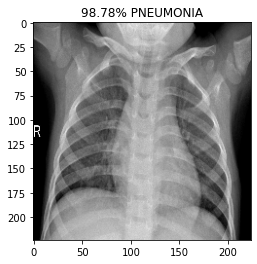

In [69]:
y_pred = model.predict(x_test_data, batch_size=64)
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% PNEUMONIA')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NORMAL')
  plt.imshow(x_test_data[index])
  plt.show()

In [70]:
model.save("model_VGG16p.h5")
model.save_weights('model_VGG16p_weights.hdf5')

Text(0.5, 1.0, 'Training and validation loss')

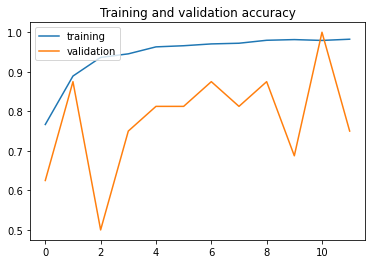

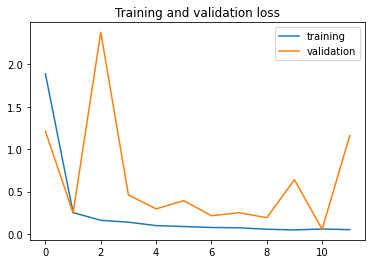

In [71]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history_vgg16.history['acc']
val_acc = history_vgg16.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')



# VGG19 Model

In [72]:
from keras.applications.vgg19 import VGG19

In [73]:
#la taille de notre input
taille=(224, 224,3)
#importer le model vgg19
model_vgg19 = VGG19(input_shape=taille, include_top=False, weights='imagenet')

80150528/80134624 [==============================] - 3s 0us/step


In [74]:
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## construction du modele

In [75]:
# Freeze the base_model
model_vgg19.trainable = False

In [76]:
model_vgg19.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [77]:
# ajouter un MaxPooling2D
x = layers.GlobalMaxPooling2D()(model_vgg19.output)
# ajouter une couche a  512 et ReLU comme activation
x = layers.Dense(512, activation='relu')(x)
# ajouter dropout rate of 0.5
x = layers.Dropout(0.2)(x)
# Ajout d’une couche entièrement connectée avec 256 unités cachées et activation ReLU
x = layers.Dense(256, activation='relu')(x)
# Ajout d’une couche entièrement connectée avec 128 unités cachées et activation ReLU
x = layers.Dense(128, activation='relu')(x)
# Ajouter une couche sigmoïde finale pour la classification
x = layers.Dense(2, activation='softmax')(x)

# Configurer et compiler le modèle
model = Model(model_vgg19.input, x)


In [78]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [79]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [80]:
history_vgg19 = model.fit(x_train_data, y_train_data, batch_size=64, epochs=3,
                    validation_data=(x_val_data, y_val_data))

Epoch 1/3
82/82 [==============================] - 46s 530ms/step - loss: 0.3768 - accuracy: 0.8379 - val_loss: 0.2581 - val_accuracy: 0.8750
Epoch 2/3
82/82 [==============================] - 43s 520ms/step - loss: 0.1565 - accuracy: 0.9394 - val_loss: 0.7653 - val_accuracy: 0.6875
Epoch 3/3
82/82 [==============================] - 43s 521ms/step - loss: 0.1280 - accuracy: 0.9504 - val_loss: 0.1973 - val_accuracy: 0.8750


## Fine Tuning Model

In [81]:
model_vgg19.trainable

False

In [82]:
model_vgg19.trainable = True
model_vgg19.trainable

True

In [83]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [84]:
history_vgg19 = model.fit(x_train_data, y_train_data, batch_size=64, epochs=12,
                    validation_data=(x_val_data, y_val_data))

Epoch 1/12
82/82 [==============================] - 43s 519ms/step - loss: 0.1095 - accuracy: 0.9595 - val_loss: 0.2314 - val_accuracy: 0.9375
Epoch 2/12
82/82 [==============================] - 43s 520ms/step - loss: 0.1046 - accuracy: 0.9611 - val_loss: 0.3899 - val_accuracy: 0.8750
Epoch 3/12
82/82 [==============================] - 43s 520ms/step - loss: 0.0943 - accuracy: 0.9647 - val_loss: 0.1764 - val_accuracy: 0.9375
Epoch 4/12
82/82 [==============================] - 43s 519ms/step - loss: 0.0971 - accuracy: 0.9628 - val_loss: 0.1447 - val_accuracy: 0.8750
Epoch 5/12
82/82 [==============================] - 43s 520ms/step - loss: 0.0951 - accuracy: 0.9647 - val_loss: 0.1532 - val_accuracy: 0.9375
Epoch 6/12
82/82 [==============================] - 43s 521ms/step - loss: 0.0825 - accuracy: 0.9701 - val_loss: 0.2061 - val_accuracy: 0.8750
Epoch 7/12
82/82 [==============================] - 43s 520ms/step - loss: 0.0844 - accuracy: 0.9688 - val_loss: 0.2233 - val_accuracy: 0.9375

In [85]:
loss_val, acc_val = model.evaluate(x_val_data, y_val_data, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1/1 [==============================] - 0s 173ms/step - loss: 1.0140 - accuracy: 0.6875
Validation: accuracy = 0.687500  ;  loss_v = 1.013963


## Testing

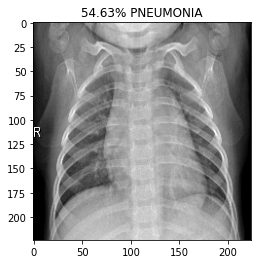

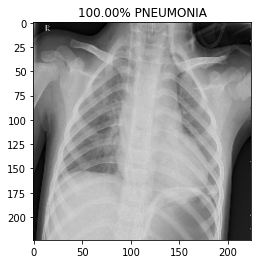

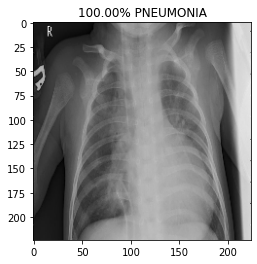

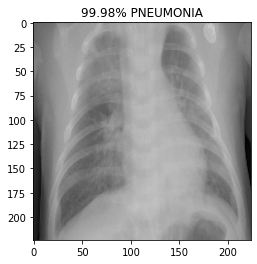

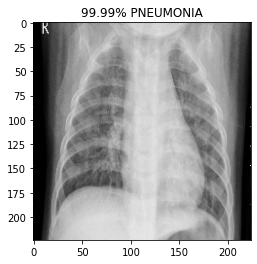

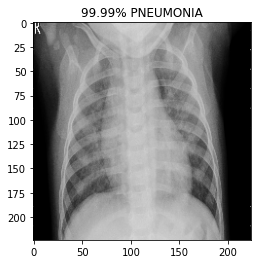

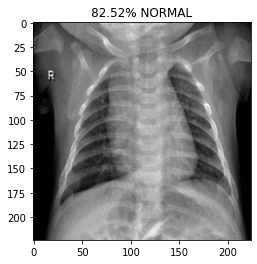

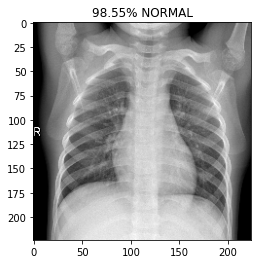

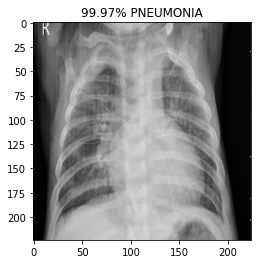

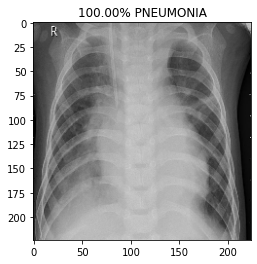

In [86]:
y_pred = model.predict(x_train_data, batch_size=64)
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% PNEUMONIA')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NORMAL')
  plt.imshow(x_train_data[index])
  plt.show()

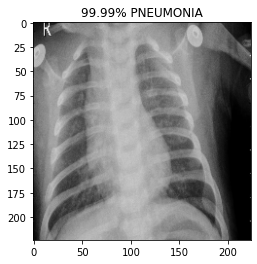

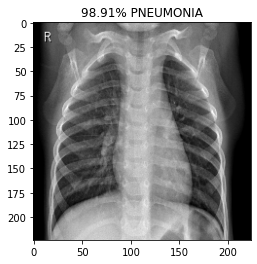

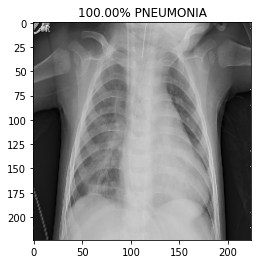

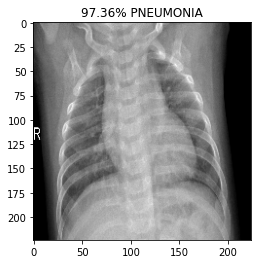

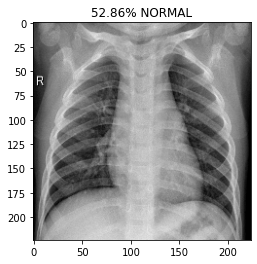

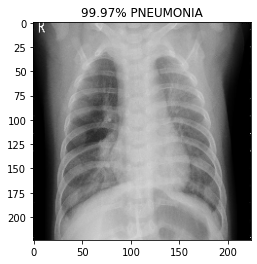

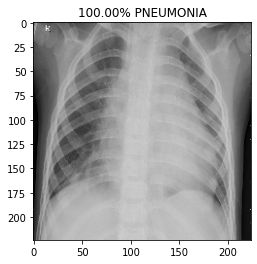

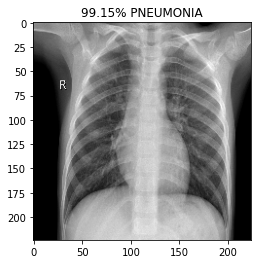

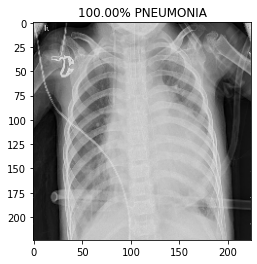

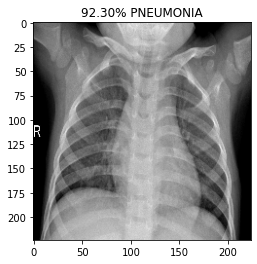

In [87]:
y_pred = model.predict(x_test_data, batch_size=64)
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% PNEUMONIA')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NORMAL')
  plt.imshow(x_test_data[index])
  plt.show()

In [88]:
loss_test_vgg19, acc_test_vgg19 = model.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (loss_test_vgg19, acc_test_vgg19))

20/20 [==============================] - 5s 266ms/step - loss: 1.7812 - accuracy: 0.6699
Test: accuracy = 1.781238  ;  loss = 0.669872


In [89]:
a = history_vgg19.history

Text(0.5, 1.0, 'Training and validation loss')

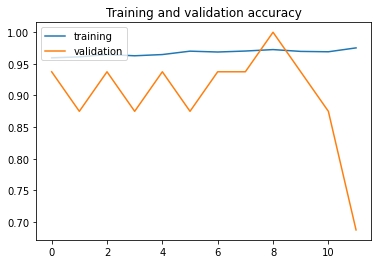

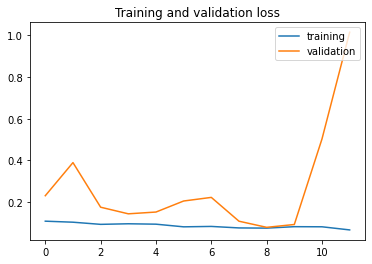

In [90]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history_vgg19.history['accuracy']
val_acc = history_vgg19.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

# InceptionV3

In [91]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [92]:
model_v3 = InceptionV3(input_shape=taille, include_top=False, weights="imagenet")

87924736/87910968 [==============================] - 1s 0us/step


In [93]:
model_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [94]:
model_v3.output

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'mixed10')>

## construction du modele

In [95]:
# Freeze the base_model
model_v3.trainable = False

In [96]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(model_v3.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='softmax')(x)

# Configure and compile the model
model = Model(model_v3.input, x)


In [97]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

## Fine Tuning Model



In [98]:
model_v3.trainable

False

In [99]:
model_vgg16.trainable = True
model_vgg16.trainable

True

In [100]:
y_val_data.shape

(16, 2)

In [101]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

In [102]:
history_v3 = model.fit(x_train_data, y_train_data, batch_size=64, epochs=12,
                    validation_data=(x_val_data, y_val_data))

Epoch 1/12
82/82 [==============================] - 58s 416ms/step - loss: 1.9013 - acc: 0.7720 - val_loss: 0.7146 - val_acc: 0.6875
Epoch 2/12
82/82 [==============================] - 23s 280ms/step - loss: 0.2010 - acc: 0.9204 - val_loss: 0.4455 - val_acc: 0.8750
Epoch 3/12
82/82 [==============================] - 23s 280ms/step - loss: 0.1682 - acc: 0.9356 - val_loss: 0.3148 - val_acc: 0.8750
Epoch 4/12
82/82 [==============================] - 23s 277ms/step - loss: 0.1702 - acc: 0.9260 - val_loss: 0.4455 - val_acc: 0.8125
Epoch 5/12
82/82 [==============================] - 23s 277ms/step - loss: 0.1460 - acc: 0.9397 - val_loss: 0.4639 - val_acc: 0.8125
Epoch 6/12
82/82 [==============================] - 23s 279ms/step - loss: 0.1338 - acc: 0.9471 - val_loss: 0.3138 - val_acc: 0.9375
Epoch 7/12
82/82 [==============================] - 23s 279ms/step - loss: 0.1333 - acc: 0.9458 - val_loss: 0.5850 - val_acc: 0.6875
Epoch 8/12
82/82 [==============================] - 23s 278ms/step - 

In [103]:
loss_val_v3, acc_val_v3 = model.evaluate(x_val_data, y_val_data, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val_v3, loss_val_v3))

1/1 [==============================] - 0s 143ms/step - loss: 0.6941 - acc: 0.6875
Validation: accuracy = 0.687500  ;  loss_v = 0.694123


## Testing

In [104]:
loss_test_v3, acc_test_v3 = model.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (loss_test_v3, acc_test_v3))

20/20 [==============================] - 3s 161ms/step - loss: 0.8685 - acc: 0.7596
Test: accuracy = 0.868501  ;  loss = 0.759615


Text(0.5, 1.0, 'Training and validation loss')

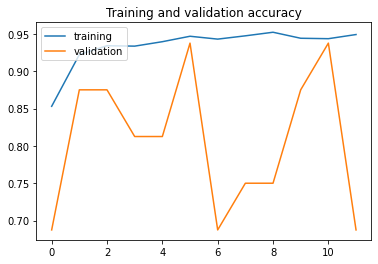

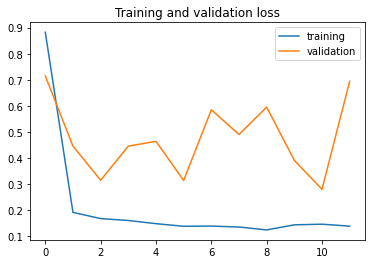

In [105]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history_v3.history['acc']
val_acc = history_v3.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history_v3.history['loss']
val_loss = history_v3.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

# ResNet

In [106]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [107]:
model_ResNet= InceptionResNetV2(input_shape=taille, include_top=False, weights="imagenet")


219070464/219055592 [==============================] - 4s 0us/step


## construction du modele

In [108]:
model_ResNet.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
________________________________________________________________________________

In [109]:
# Freeze the base_model
model_ResNet.trainable = False
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(model_ResNet.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='softmax')(x)

# Configure and compile the model
model = Model(model_ResNet.input, x)

## Fine Tuning Model

In [110]:
model_ResNet.trainable

False

In [111]:
model_ResNet.trainable = True
model_ResNet.trainable

True

In [112]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

In [113]:
history_ResNet = model.fit(x_train_data, y_train_data, batch_size=64, epochs=12,
                    validation_data=(x_val_data, y_val_data))

Epoch 1/12
82/82 [==============================] - 269s 3s/step - loss: 0.8230 - acc: 0.7992 - val_loss: 1.5026 - val_acc: 0.5000
Epoch 2/12
82/82 [==============================] - 194s 2s/step - loss: 0.0882 - acc: 0.9676 - val_loss: 0.9167 - val_acc: 0.6250
Epoch 3/12
82/82 [==============================] - 194s 2s/step - loss: 0.0362 - acc: 0.9898 - val_loss: 1.1079 - val_acc: 0.6875
Epoch 4/12
82/82 [==============================] - 194s 2s/step - loss: 0.0271 - acc: 0.9937 - val_loss: 0.6325 - val_acc: 0.8750
Epoch 5/12
82/82 [==============================] - 194s 2s/step - loss: 0.0081 - acc: 0.9978 - val_loss: 0.7981 - val_acc: 0.8750
Epoch 6/12
82/82 [==============================] - 194s 2s/step - loss: 0.0080 - acc: 0.9975 - val_loss: 0.7000 - val_acc: 0.8750
Epoch 7/12
82/82 [==============================] - 194s 2s/step - loss: 0.0038 - acc: 0.9994 - val_loss: 0.6102 - val_acc: 0.8750
Epoch 8/12
82/82 [==============================] - 194s 2s/step - loss: 0.0014 - a

In [114]:
loss_val_RN, acc_val_RN = model.evaluate(x_val_data, y_val_data, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (loss_val_RN, acc_val_RN))

1/1 [==============================] - 0s 247ms/step - loss: 0.4296 - acc: 0.8750
Validation: accuracy = 0.429583  ;  loss_v = 0.875000


## Testing

In [115]:
loss_test_RN, acc_test_RN = model.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (loss_test_RN, acc_test_RN))

20/20 [==============================] - 8s 381ms/step - loss: 1.5120 - acc: 0.7933
Test: accuracy = 1.512043  ;  loss = 0.793269


Text(0.5, 1.0, 'Training and validation loss')

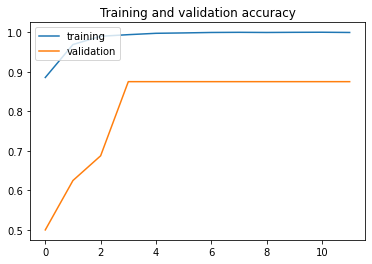

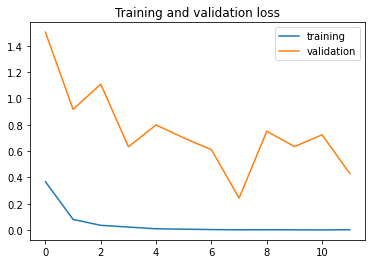

In [116]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history_ResNet.history['acc']
val_acc = history_ResNet.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history_ResNet.history['loss']
val_loss = history_ResNet.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')